## Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [1]:
import numpy as np
from numba import jit, njit, vectorize, cuda, int64, float32, int32, int16
import math as m

A = np.array([2, 5, 10, 3, 8], dtype='float32')

@vectorize([float32(float32)], target='parallel', fastmath=True)
def vec_log(x):
    return m.log(x)

@vectorize([float32(float32)], target='parallel', fastmath=True)
def vec_exp(x):
    return m.exp(x)

print("Log:", vec_log(A))
print("Exp:", vec_exp(A))

Log: [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
Exp: [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]


## Exerice 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

In [2]:
@vectorize([float32(float32)], target='parallel', fastmath=True)
def gaussian(x):
    mean = 1
    sigma  = 1
    return 1/(np.sqrt(2*m.pi)*sigma)*np.exp(-((x-mean)/sigma)**2 /2)
    
x=np.linspace(-10,10,100000,dtype='float32')

gaussian(x)



array([2.1188193e-27, 2.1234920e-27, 2.1281528e-27, ..., 1.0316809e-18,
       1.0298319e-18, 1.0279774e-18], dtype=float32)

## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$thresold = 15$

[Text(0, 0.5, 'pulses'), Text(0.5, 0, 'time [s]')]

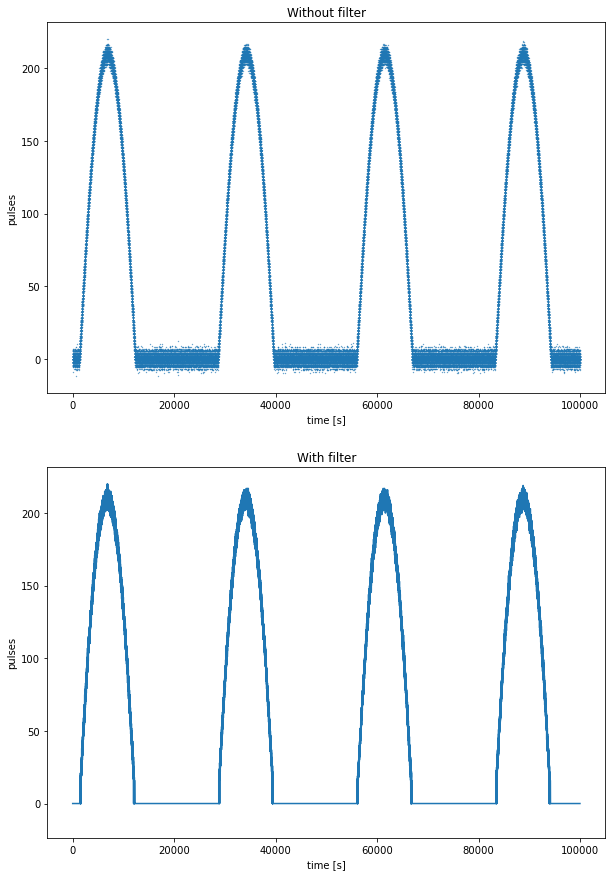

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)

#put your code here
@vectorize([float32(float32)], target='parallel', fastmath=True)
def supp_zero(x):
    if x>15: return x
    else: return 0

fig, axs = plt.subplots(2,figsize=(10,15),sharey=True)
axs[0].plot(data,'.',markersize=0.6)
axs[0].set_title('Without filter')


axs[1].plot(supp_zero(data))
axs[1].set_title('With filter')

axs[0].set(xlabel='time [s]', ylabel='pulses')
axs[1].set(xlabel='time [s]', ylabel='pulses')

## Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [4]:
X = np.random.rand(3,3)
Y = np.random.rand(3,3)


@cuda.jit
def sigmoid_kernel(x,y,k,a,c):
    row,col=cudas.grid(2)
    
    if row < k.shape[0] and col < k.shape[1]:
        k[row][col]=math.tanh(np.dot(x[row,:],y[:,col]))
        
k=np.zeros((3,3), dtype='float32')        

sigmoid_kernel[(1,1), (3,3)](X, Y, k, 1., 0.)

CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:

## Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

In [5]:

@cuda.jit
def cos_kernel_3D(io_array):
    row, col, l = cuda.grid(3)
    if row < io_array.shape[0] and col < io_array.shape[1] and l < io_array.shape[2]:
        io_array[row][col][l] *= m.cos(io_array[row][col][l])
        
x = np.random.normal(size=(256,256,256))

threadsperblock = (16, 16)
blockspergrid_x = int(m.ceil(x.shape[0] / threadsperblock[0]))
blockspergrid_y = int(m.ceil(x.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)


cos_kernel_3D[blockspergrid, threadsperblock](x)
#print(x)

CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:

## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x12$

A and B must be randomly generated and only int values are allowed.


In [6]:
from __future__ import division
from numba import cuda
import numpy
import math

# complete the code
@cuda.jit
def matmul(A, B, C):
    """Perform matrix multiplication of C = A * B
    """
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

# Initialize the data arrays
A = np.random.random((24,12))
B = np.random.random((12,22))

# Configure the blocks
threadsperblock = (24, 22)
blockspergrid_x = 1
blockspergrid_y = 1
blockspergrid = (blockspergrid_x, blockspergrid_y)

C = np.zeros((24,22))
matmul[blockspergrid, threadsperblock](A, B, C)


np.all(np.matmul(A,B) == C)

CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
: